# Conservative Q-Learning for Offline Reinforcement Learning 
 
> Name: Payam Taebi

> SID: 400104867



## Introduction
Conservative Q-Learning, CQL, aims to solve the overestimaion of values in offline RL algortihms by learning a conservative Q-function such that the expected value of a policy under this Q-function lower-bounds its true value. 

## Preliminaries
#### **Notations** 
* $T(s'|s,a)$ : The probability of $s\rightarrow a \rightarrow s'$
* $\mathcal{D}$ : the dataset of states sampled from $d^{\pi_{\beta}}(s)\pi_{\beta}$
* $r(s,a)$ : reward, $\gamma$ :discount factor
* ${\pi}_{\beta}(a|s)$ : behavior policy
* $\hat{\pi}_{\beta}(a|s)$ := $\frac{\sum_{s, a \in \mathcal{D}}1[s=s, a=a]}{\sum_{s, a \in \mathcal{D}}1[s=s]}$ : the empirical behavior policy
* $d^{\pi_{\beta}}(s)$ : the discount marginal state-distribution of $\pi_{\beta}(a|s)$
* $\mu (s,a)$ : a distribution of state-action pairs


#### **Assumptions**
* Assume the reward is bounded : $|r(s,a)| \leq R_\text{max}$


#### **Original Q-learning** 
* Bellman operator

$$
\mathcal{B}^{\pi} Q = r + \gamma P^{\pi} Q, \quad 
P^{\pi} Q(s,a) = \mathbb{E}_{s' \sim T(s'|s,a),\ a' \sim \pi(a'|s')} \left[ Q(s', a') \right]
$$

    
* train Q-function by iteratively applying **Bellman optimality operator**: 

    $$\mathcal{B}^*Q(s,a) = r(s,a) + \gamma\mathbb{E}_{s'\sim P(s'|s,a)}[\max_{a'}Q(s',a')]$$
    
* The empirical Bellman operator $\hat{\mathcal{B}}^{\pi}$ only contains a single sample in $\mathcal{D}$. 

    $$\hat{\mathcal{B}}^{\pi} \hat{Q}^k(s,a) = r(s,a) + \gamma \mathbb{E}_{a'\sim\hat{\pi}(a'|s')}[\hat Q^k(s',a')]$$

* Try to constrain $a'$ to stay close to behavior policy in Q-learning. In this case, it is able to avoid querying $Q$ on out-of-distribution(OOD) actions. Set a original Q-learning policy evaluation :

$$\hat{Q}^{k+1} \gets \arg\min_Q \mathbb{E}_{s,a,s'\sim D} \left[\left((r(s,a) + \gamma \mathbb{E}{a'\sim\hat{\pi}^k(a'|s')}[\hat{Q}^k(s',a')]) - Q(s,a)\right)^2\right]$$

* Original Q-learning policy improvement

$$
\hat{\pi}^{k+1} \gets \arg\max_\pi \mathbb{E}_{s \sim D, a \sim \pi^k(a|s)} \left[ \hat{Q}^{k+1}(s,a) \right]
$$


### Problems in Offline RL Algorithms
In practice, offline RL has encountered major challenge in offline RL is the distribution shift between the dataset and the learned policy, which can lead to ***overestimation*** of values for out-of-distribution actions.




## Conservative Q-Learning (CQL)
### Conservative Off-Policy Evaluation
* To be conservative, try to add penalty into the policy evaluation algorithm. The paper chose to restrict $\mu$, by letting $\mu(s,a) = d^{\pi_{\beta}}(s)\pi_{\beta}$. Simply view the $\color{yellow}{yellow}$ part as a penalty to push down $(\downarrow
)$ big Q-values: 

$$
\hat{Q}^{k+1} \leftarrow {\arg\min}_{Q}\ 
\textcolor{yellow}{\alpha \mathbb{E}_{s \sim D, a \sim \mu(a|s)} [Q(s,a)]} 
+ \frac{1}{2} \mathbb{E}_{s,a,s' \sim D} \left[ \left( Q(s,a) - \hat{B}^{\pi} \hat{Q}^k(s,a) \right)^2 \right]
\quad\quad (1)
$$

* It has been proved in *Theorem 3.1* of the paper that the Eq. (1) lower-bounds the true Q-function $Q^{\pi}$. 

* The bound can be tightened if we only require the expected value of $\hat{Q}^{\pi}$ under the policy $\pi(a|s)$ and a lower bound on $V^{\pi}$. We can improve the bound by introducing an additional Q-value maximization term. In practice, adding the $\color{red}{red}$ term encourages an upward push $(\uparrow)$ on Q-values for $(s, a)$ samples from the dataset. Revise Eq. (1) as follows: 

$$
\hat{Q}^{k+1} \leftarrow {\arg\min}_{Q}\ 
\alpha \left( 
\mathbb{E}_{s \sim D, a \sim \mu(a|s)} [Q(s,a)] 
{\color{red}{ - \mathbb{E}_{s \sim D, a \sim \hat{\pi}_{\beta}(a|s)} [Q(s,a)]}}
\right)
+ \frac{1}{2} \mathbb{E}_{s,a,s' \sim D} \left[ \left( Q(s,a) - \hat{B}^{\pi} \hat{Q}^k(s,a) \right)^2 \right]
\quad\quad (2)
$$


* It has been proved in *Theorem 3.2* of the paper that the Eq. (2) lower-bounds the expected value under the policy $\pi$, when $\mu = \pi$.
### Conservative Q-Learning for Offline RL
* With taking $\mu(s,a) = d^{\pi_{\beta}}(s)\pi_{\beta}$, since the policy $\hat{\pi}^k$ is derived from Q-function, we could instead choose $\mu(s,a)$ to approximate the policy that would maximize the current Q-function iterate. 
* Denote $\text{CQL}(\mathcal{R})$ with a chosen regularizer $\mathcal{R}(\mu)$. In practice, adding the $\textcolor{lightgreen}{\text{green}}$ term enables us to find a closed-form solution for the inner maximization, bypassing the need to calculate (or optimize) it at each step: 

$$
\min_Q \, \textcolor{lightgreen}{\max}_{\textcolor{lightgreen}{\mu}} \, 
\alpha \left( 
\mathbb{E}_{s \sim \mathcal{D}, a \sim \mu(a|s)} \left[ Q(s, a) \right] 
- 
\mathbb{E}_{s \sim \mathcal{D}, a \sim \hat{\pi}_\beta(a|s)} \left[ Q(s, a) \right] 
\right) 
+ \frac{1}{2} \mathbb{E}_{s, a, s' \sim \mathcal{D}} \left[ \left( Q(s, a) - \hat{\mathcal{B}}^{\pi_k} \hat{Q}^k(s, a) \right)^2 \right] 
+ \textcolor{lightgreen}{\mathcal{R}(\mu)} 
\quad \left( \text{CQL}(\mathcal{R}) \right) \quad\quad (3)
$$


* "conservative" indicates the sense that each successive policy iterate is optimized against a lower bound on its value. $\text{CQL}$ is say to be conservative by showing that $\text{CQL}(\mathcal H)$ learns Q-value estimates that lower-bound the actual Q-function. It has been proved in *Theorem 3.3* that $\text{CQL}$ learns lower-bounded Q-values with large enough $\alpha$, meaning that the final policy attains the estimated value. 

* The paper also shows that $\text{CQL}$ optimizes a well-defined, penalized empirical RL objective, and performs high-confidence safe policy improvement over the behavior policy. 

### Regulizer and Variant of CQL

* The paper provides several variants of CQL based on different regularizers. One of the most common is $\text{CQL}(\mathcal{H})$, which corresponds to maximum entropy regularization. (The disscussion of CQL variants is in Appendices P.14). By replacing the optimal closed-form solution of the inner maximization with $\mu^{*}$, the final objective of $\text{CQL}(\mathcal{H})$ is as follows: 
    $$
    \text{CQL}(\mathcal H) := \min_Q \ \alpha \mathbb{E}_{s \sim \mathcal{D}} \left[ \log \sum_a \exp(Q(s, a)) - \mathbb{E}_{a \sim \hat{\pi}_\beta(a|s)} \left[ Q(s, a) \right] \right] + \frac{1}{2} \mathbb{E}_{s, a, s' \sim \mathcal{D}} \left[ \left( Q - \hat{\mathcal{B}}^{\pi_k} \hat{Q}^k \right)^2 \right] \quad\quad (4)
    $$

* Another approach: choose ${\mathcal{R} (\mu)}$ to be the KL-divergence against a prior distribution $\rho (a|s)$, i.e. $\mathcal{R}(\mu) = -D_{KL}(\mu, \rho)$.

Show the derivation of Eq. (4).

**Answer (I)**: **<span style="color:red">TODO</span>**

## Derivation of Eq. (4)

To obtain Eq. (4), we start from the CQL(\(\mathcal H\)) objective in Eq. (3):

$$
\min_Q \; \max_{\mu}\; \alpha\Bigl(
\mathbb{E}_{s\sim\mathcal{D},\,a\sim\mu(a|s)}[Q(s,a)]
- 
\mathbb{E}_{s\sim\mathcal{D},\,a\sim\hat\pi_\beta(a|s)}[Q(s,a)]
\Bigr)
\;+\;\frac12\,\mathbb{E}_{s,a,s'\sim\mathcal{D}}\Bigl(Q(s,a)-\hat{\mathcal{B}}^{\pi_k}\hat Q^k(s,a)\Bigr)^2
\;+\;\mathcal{H}(\mu)\,.
$$

1. **Inner maximization w.r.t. \(\mu\)**  
   For each fixed \(s\), consider
   $$
   \max_{\mu(\cdot|s)}\;\mathbb{E}_{a\sim\mu(\cdot|s)}\bigl[Q(s,a)\bigr]
   \;+\;\mathcal{H}\bigl(\mu(\cdot|s)\bigr).
   $$
   This is the well‑known entropy‑regularized reward maximization, whose solution is the Gibbs (softmax) distribution:
   $$
   \mu^*(a|s)
   = \frac{\exp\bigl(Q(s,a)\bigr)}{\sum_{a'}\exp\bigl(Q(s,a')\bigr)},
   $$
   and the optimal value is
   $$
   \log\sum_a \exp\bigl(Q(s,a)\bigr).
   $$

2. **Substitute back into the outer problem**  
   Replacing the \(\max_\mu\) by its closed‑form value gives
   $$
   \min_Q\;\alpha\,
   \mathbb{E}_{s\sim\mathcal{D}}\Bigl[
     \log\sum_a\exp\bigl(Q(s,a)\bigr)
     \;-\;
     \mathbb{E}_{a\sim\hat\pi_\beta(a|s)}\bigl[Q(s,a)\bigr]
   \Bigr]
   \;+\;\frac12\,\mathbb{E}_{s,a,s'\sim\mathcal{D}}\Bigl(Q(s,a)-\hat{\mathcal{B}}^{\pi_k}\hat Q^k(s,a)\Bigr)^2,
   $$
   which is exactly Eq. (4).


---
# Implementation

Now, you are required to implement a `CQL-SAC` training pipeline on the `Pendulum` environment. To validate your implementation, you should:

- Plot the training reward of your agent, highlighting its convergence (the reward should steadily increase).
- Compare the performance of the trained agent with that of a randomly initialized agent over several validation trajectories.


#### **Imports**

In [1]:
import os
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import numpy as np
import math
import copy
from torch.distributions import Normal
import gym
import numpy as np
from collections import deque
import torch
import argparse
import random
import numpy as np
np.bool8 = np.bool_

import random
import torch
from collections import deque, namedtuple

#### **Some Useful Functions**

In [2]:
##############################################
# no need to do any thing,
# However, you can change it if needed
##############################################

def save(args, save_name, model, wandb, ep=None):
    import os
    save_dir = './trained_models/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not ep == None:
        torch.save(model.state_dict(), save_dir + args.run_name + save_name + str(ep) + ".pth")
        wandb.save(save_dir + args.run_name + save_name + str(ep) + ".pth")
    else:
        torch.save(model.state_dict(), save_dir + args.run_name + save_name + ".pth")
        wandb.save(save_dir + args.run_name + save_name + ".pth")

def collect_random(env, dataset, num_samples=200):
    state = env.reset()
    for _ in range(num_samples):
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        dataset.add(state, action, reward, next_state, done)
        state = next_state
        if done:
            state = env.reset()

def evaluate(env, policy, eval_runs=5):
    """
    Makes an evaluation run with the current policy
    """
    reward_batch = []
    for i in range(eval_runs):
        state = env.reset()

        rewards = 0
        while True:
            action = policy.get_action(state, eval=True)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            rewards += reward
            if done:
                break
        reward_batch.append(rewards)
    return np.mean(reward_batch)

#### **Replay Buffer**

In [3]:
##############################################
# no need to do any thing,
# However, you can change it if needed
##############################################

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.device = device
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


#### **(Soft) Actor \& Critic**

In [4]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, hidden_size=32, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(Actor, self).__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        # shared backbone MLP
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        
        # mu and log_std heads
        self.mu_head = nn.Linear(hidden_size, action_size)
        self.log_std_head = nn.Linear(hidden_size, action_size)

        # initialize final layers
        self.mu_head.weight.data.uniform_(-init_w, init_w)
        self.mu_head.bias.data.uniform_(-init_w, init_w)
        self.log_std_head.weight.data.uniform_(-init_w, init_w)
        self.log_std_head.bias.data.uniform_(-init_w, init_w)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu_head(x)
        log_std = self.log_std_head(x).clamp(self.log_std_min, self.log_std_max)
        return mu, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)
        e = dist.rsample().to(state.device)
        
        # tanh-squashed action
        action = torch.tanh(mu + e)
        
        # log_prob with change-of-variable correction:
        # $$\log \pi(a|s) = \log \mathcal{N}(e;\,0,I) - \sum_i \log\bigl(1 - a_i^2 + \epsilon\bigr)$$
        log_prob = (dist.log_prob(e) - torch.log(1 - action.pow(2) + epsilon)).sum(1, keepdim=True)
        return action, log_prob
        
    def get_action(self, state):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        dist = Normal(mu, std)
        e = dist.rsample().to(state.device)
        action = torch.tanh(mu + e)
        return action.detach().cpu()
    
    def get_det_action(self, state):
        mu, _ = self.forward(state)
        return torch.tanh(mu).detach().cpu()


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, hidden_size=32, seed=1):
        super(Critic, self).__init__()
        torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size + action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        # initialize final layer
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        self.fc3.bias.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        q_value = self.fc3(x)
        return q_value


In [5]:
class CQLSAC(nn.Module):
    """Interacts with and learns from the environment."""

    def __init__(self,
                 state_size,
                 action_size,
                 tau,
                 hidden_size,
                 learning_rate,
                 temp,
                 cql_weight,
                 target_action_gap,
                 device
                ):
        super(CQLSAC, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.device = device

        self.gamma = torch.FloatTensor([0.99]).to(device)
        self.tau = tau
        self.clip_grad_param = 1

        self.target_entropy = -action_size  # -dim(A)

        self.log_alpha = torch.tensor([0.0], requires_grad=True)
        self.alpha = self.log_alpha.exp().detach()
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=learning_rate)

        # CQL params
        self.temp = temp
        self.cql_weight = cql_weight
        self.target_action_gap = target_action_gap
        self.cql_log_alpha = torch.zeros(1, requires_grad=True)
        self.cql_alpha_optimizer = optim.Adam(params=[self.cql_log_alpha], lr=learning_rate)

        # Actor Network
        self.actor_local = Actor(state_size, action_size, hidden_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=learning_rate)

        # Critic Network (w/ Target Network)
        self.critic1 = Critic(state_size, action_size, hidden_size, seed=2).to(device)
        self.critic2 = Critic(state_size, action_size, hidden_size, seed=1).to(device)
        self.critic1_target = Critic(state_size, action_size, hidden_size).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())
        self.critic2_target = Critic(state_size, action_size, hidden_size).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=learning_rate)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=learning_rate)

    def get_action(self, state, eval=False):
        """Returns actions for given state as per current policy."""
        state = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        if eval:
            action = self.actor_local.get_det_action(state)
        else:
            action = self.actor_local.get_action(state)
        return action.numpy()[0]

    def calc_policy_loss(self, states, alpha):
        """
        Calculates the policy (actor) loss:
        Actor_loss = α * log π(a|s) - Q(s,a)
        """
        actions_pred, log_pis = self.actor_local.evaluate(states)
        q1 = self.critic1(states, actions_pred)
        q2 = self.critic2(states, actions_pred)
        min_Q = torch.min(q1, q2)
        actor_loss = (alpha * log_pis - min_Q).mean()
        return actor_loss, log_pis

    def _compute_policy_values(self, obs_pi, obs_q):
        # unchanged
        actions_pred, log_pis = self.actor_local.evaluate(obs_pi)
        qs1 = self.critic1(obs_q, actions_pred)
        qs2 = self.critic2(obs_q, actions_pred)
        return qs1 - log_pis.detach(), qs2 - log_pis.detach()

    def _compute_random_values(self, obs, actions, critic):
        # unchanged
        random_values = critic(obs, actions)
        random_log_probs = math.log(0.5 ** self.action_size)
        return random_values - random_log_probs

    def learn(self, experiences):
        """Updates actor, critics and entropy_alpha parameters."""
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update actor ---------------------------- #
        current_alpha = copy.deepcopy(self.alpha)
        actor_loss, log_pis = self.calc_policy_loss(states, current_alpha)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ---------------------------- update alpha ---------------------------- #
        alpha_loss = - (self.log_alpha.exp() * (log_pis + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        self.alpha = self.log_alpha.exp().detach()

        # ---------------------------- update critic ---------------------------- #
        with torch.no_grad():
            next_action, new_log_pi = self.actor_local.evaluate(next_states)
            Q_target1_next = self.critic1_target(next_states, next_action)
            Q_target2_next = self.critic2_target(next_states, next_action)
            Q_target_next = torch.min(Q_target1_next, Q_target2_next) - self.alpha * new_log_pi
            Q_targets = rewards + (1 - dones) * self.gamma * Q_target_next

        q1 = self.critic1(states, actions)
        q2 = self.critic2(states, actions)
        critic1_loss = F.mse_loss(q1, Q_targets)
        critic2_loss = F.mse_loss(q2, Q_targets)

        # ------------------------ CQL Addon ------------------------ #
        random_actions = torch.FloatTensor(q1.shape[0] * 10, actions.shape[-1]).uniform_(-1, 1).to(self.device)
        num_repeat = int(random_actions.shape[0] / states.shape[0])
        temp_states = states.unsqueeze(1).repeat(1, num_repeat, 1).view(-1, states.shape[1])
        temp_next_states = next_states.unsqueeze(1).repeat(1, num_repeat, 1).view(-1, next_states.shape[1])

        current_pi_values1, current_pi_values2 = self._compute_policy_values(temp_states, temp_states)
        next_pi_values1, next_pi_values2     = self._compute_policy_values(temp_next_states, temp_states)
        random_values1 = self._compute_random_values(temp_states, random_actions, self.critic1).view(states.shape[0], num_repeat, 1)
        random_values2 = self._compute_random_values(temp_states, random_actions, self.critic2).view(states.shape[0], num_repeat, 1)

        current_pi_values1 = current_pi_values1.view(states.shape[0], num_repeat, 1)
        current_pi_values2 = current_pi_values2.view(states.shape[0], num_repeat, 1)
        next_pi_values1    = next_pi_values1.view(states.shape[0], num_repeat, 1)
        next_pi_values2    = next_pi_values2.view(states.shape[0], num_repeat, 1)

        cat_q1 = torch.cat([random_values1, current_pi_values1, next_pi_values1], dim=1)
        cat_q2 = torch.cat([random_values2, current_pi_values2, next_pi_values2], dim=1)

        cql1_scaled_loss = (
            torch.logsumexp(cat_q1 / self.temp, dim=1).mean() * self.temp
            - q1.mean()
        ) * self.cql_weight
        cql2_scaled_loss = (
            torch.logsumexp(cat_q2 / self.temp, dim=1).mean() * self.temp
            - q2.mean()
        ) * self.cql_weight

        cql_alpha_loss = torch.tensor(0.0)
        cql_alpha = torch.tensor(0.0)

        total_c1_loss = critic1_loss + cql1_scaled_loss
        total_c2_loss = critic2_loss + cql2_scaled_loss

        # update critics
        self.critic1_optimizer.zero_grad()
        total_c1_loss.backward(retain_graph=True)
        clip_grad_norm_(self.critic1.parameters(), self.clip_grad_param)
        self.critic1_optimizer.step()

        self.critic2_optimizer.zero_grad()
        total_c2_loss.backward()
        clip_grad_norm_(self.critic2.parameters(), self.clip_grad_param)
        self.critic2_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic1, self.critic1_target)
        self.soft_update(self.critic2, self.critic2_target)

        return (
            actor_loss.item(), alpha_loss.item(),
            critic1_loss.item(), critic2_loss.item(),
            cql1_scaled_loss.item(), cql2_scaled_loss.item(),
            current_alpha.item(), cql_alpha_loss.item(), cql_alpha.item()
        )

    def soft_update(self, local_model, target_model):
        """Soft update model parameters."""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)


In [6]:
def get_config():
    parser = argparse.ArgumentParser(description='RL')
    parser.add_argument("--run_name", type=str, default="CQL-SAC", help="Run name, default: CQL-SAC")
    parser.add_argument("--env", type=str, default="Pendulum-v1", help="Gym environment name, default: Pendulum-v0")
    parser.add_argument("--episodes", type=int, default=200, help="Number of episodes, default: 200")
    parser.add_argument("--buffer_size", type=int, default=100_000, help="Maximal training dataset size, default: 100_000")
    parser.add_argument("--seed", type=int, default=1, help="Seed, default: 1")
    parser.add_argument("--log_video", type=int, default=0, help="Log agent behaviour to wanbd when set to 1, default: 0")
    parser.add_argument("--save_every", type=int, default=100, help="Saves the network every x epochs, default: 25")
    parser.add_argument("--batch_size", type=int, default=256, help="Batch size, default: 256")
    parser.add_argument("--hidden_size", type=int, default=256, help="")
    parser.add_argument("--learning_rate", type=float, default=3e-4, help="")
    parser.add_argument("--temperature", type=float, default=1.0, help="")
    parser.add_argument("--cql_weight", type=float, default=1.0, help="")
    parser.add_argument("--target_action_gap", type=float, default=10, help="")
    parser.add_argument("--tau", type=float, default=5e-3, help="")

    args = parser.parse_args()
    return args

In [7]:
##############################################
# no need to do any thing,
# However, you can change it if needed
##############################################

import matplotlib.pyplot as plt
import numpy as np
import random
import os
import torch
from collections import deque

def train(config):
    np.random.seed(config.seed)
    random.seed(config.seed)
    torch.manual_seed(config.seed)

    env      = gym.make(config.env, new_step_api=True)
    eval_env = gym.make(config.env, new_step_api=True)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    steps = 0
    average10 = deque(maxlen=10)
    total_steps = 0

    agent = CQLSAC(
        state_size=env.observation_space.shape[0],
        action_size=env.action_space.shape[0],
        tau=config.tau,
        hidden_size=config.hidden_size,
        learning_rate=config.learning_rate,
        temp=config.temperature,
        cql_weight=config.cql_weight,
        target_action_gap=config.target_action_gap,
        device=device
    )

    buffer = ReplayBuffer(buffer_size=config.buffer_size, batch_size=config.batch_size, device=device)

    collect_random(env=env, dataset=buffer, num_samples=10000)

    eval_reward = evaluate(eval_env, agent)
    print(f"Initial Test Reward: {eval_reward:.2f}")
    print('-' * 50)

    rewards_history = []    # Store per episode reward
    average10_history = []  # Store moving average

    for i in range(1, config.episodes + 1):
        state = env.reset()
        episode_steps = 0
        rewards = 0
        done = False
        while not done:
            action = agent.get_action(state)
            steps += 1

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            buffer.add(state, action, reward, next_state, done)
            policy_loss, alpha_loss, bellmann_error1, bellmann_error2, cql1_loss, cql2_loss, current_alpha, lagrange_alpha_loss, lagrange_alpha = agent.learn(buffer.sample())
            state = next_state
            rewards += reward
            episode_steps += 1

        average10.append(rewards)
        rewards_history.append(rewards)
        average10_history.append(np.mean(average10))
        total_steps += episode_steps
        print(f"Episode: {i} | Reward: {rewards:.2f} | Average10: {np.mean(average10):.2f} | Steps: {steps}")

        if i % config.save_every == 0:
            save_dir = './trained_models/'
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            torch.save(agent.actor_local.state_dict(), save_dir + config.run_name + "_CQL-DQN_" + str(i) + ".pth")
            print(f"Model saved at episode {i}")

    # Plot Reward and Average10
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    axs[0].plot(rewards_history, label='Reward per Episode')
    axs[0].set_title('Reward per Episode')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(average10_history, label='Average Reward (10 episodes)', color='orange')
    axs[1].set_title('Moving Average Reward (10 episodes)')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Average Reward')
    axs[1].legend()
    axs[1].grid()

    plt.tight_layout()
    plt.show()


Initial Test Reward: -1350.05
--------------------------------------------------
Episode: 1 | Reward: -1770.70 | Average10: -1770.70 | Steps: 200
Episode: 2 | Reward: -1286.46 | Average10: -1528.58 | Steps: 400
Episode: 3 | Reward: -1397.88 | Average10: -1485.02 | Steps: 600
Episode: 4 | Reward: -1361.65 | Average10: -1454.17 | Steps: 800
Episode: 5 | Reward: -1361.11 | Average10: -1435.56 | Steps: 1000
Episode: 6 | Reward: -1636.16 | Average10: -1468.99 | Steps: 1200
Episode: 7 | Reward: -1072.39 | Average10: -1412.34 | Steps: 1400
Episode: 8 | Reward: -1200.71 | Average10: -1385.88 | Steps: 1600
Episode: 9 | Reward: -1081.35 | Average10: -1352.05 | Steps: 1800
Episode: 10 | Reward: -1044.36 | Average10: -1321.28 | Steps: 2000
Episode: 11 | Reward: -979.65 | Average10: -1242.17 | Steps: 2200
Episode: 12 | Reward: -748.16 | Average10: -1188.34 | Steps: 2400
Episode: 13 | Reward: -1175.79 | Average10: -1166.13 | Steps: 2600
Episode: 14 | Reward: -1095.74 | Average10: -1139.54 | Steps: 2

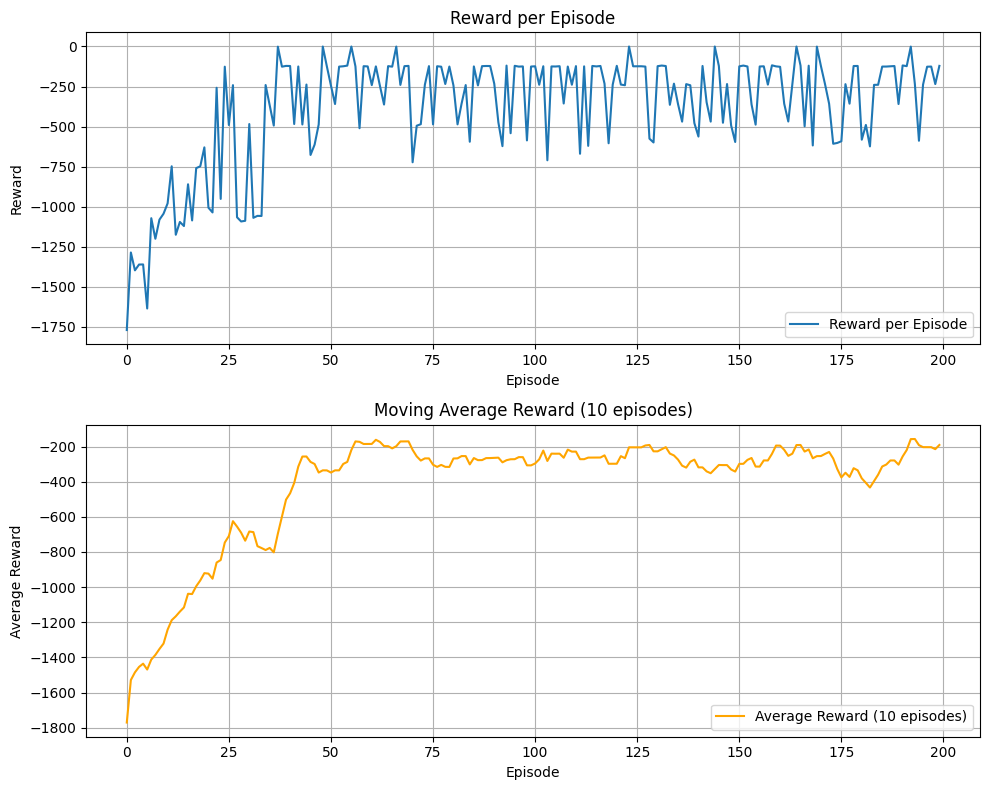

In [8]:
##############################################
# no need to do any thing,
# However, you can change it if needed
##############################################

import sys
sys.argv=['']
del sys
config = get_config()
train(config)

## Conclusion:

In this assignment, we trained a SAC agent using a relatively large offline dataset collected from a random policy, supplemented by a limited number of online interactions gathered during training. These online samples were used both for training and for evaluating the agent’s performance in newly observed states, highlighting improvements over time. While this hybrid setup enabled effective learning, it is important to note that in real-world offline RL scenarios, online interactions are often prohibited, making the problem significantly more challenging. In such cases, greater amounts of offline data and longer training periods are necessary. Through this process, we gained a deeper understanding of the intuition behind Conservative Q-Learning (CQL), its practical implementation, and why it is considered a stable and popular method for offline reinforcement learning.

# ***Best Regards.***